In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [46]:
data=pd.read_csv("/content/Google_stock.csv")

In [47]:
print("""
**********************************************
**************Data Overview******************* """)
print(data.head())
print("""
****************************************************************************************************************************************************************
""")
print(data.columns)
print("""
****************************************************************************************************************************************************************
""")
print(data.dtypes)
print("""
****************************************************************************************************************************************************************
""")
print(data.isnull().sum())
print("""
****************************************************************************************************************************************************************
""")
print(data.describe())


**********************************************
**************Data Overview******************* 
         Date       Open       High        Low      Close  Adj Close  \
0  2010-01-04  15.689439  15.753504  15.621622  15.684434  15.684434   
1  2010-01-05  15.695195  15.711712  15.554054  15.615365  15.615365   
2  2010-01-06  15.662162  15.662162  15.174174  15.221722  15.221722   
3  2010-01-07  15.250250  15.265265  14.831081  14.867367  14.867367   
4  2010-01-08  14.814815  15.096346  14.742492  15.065566  15.065566   

      Volume  
0   78169752  
1  120067812  
2  158988852  
3  256315428  
4  188783028  

****************************************************************************************************************************************************************

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

**********************************************************************************************************************************

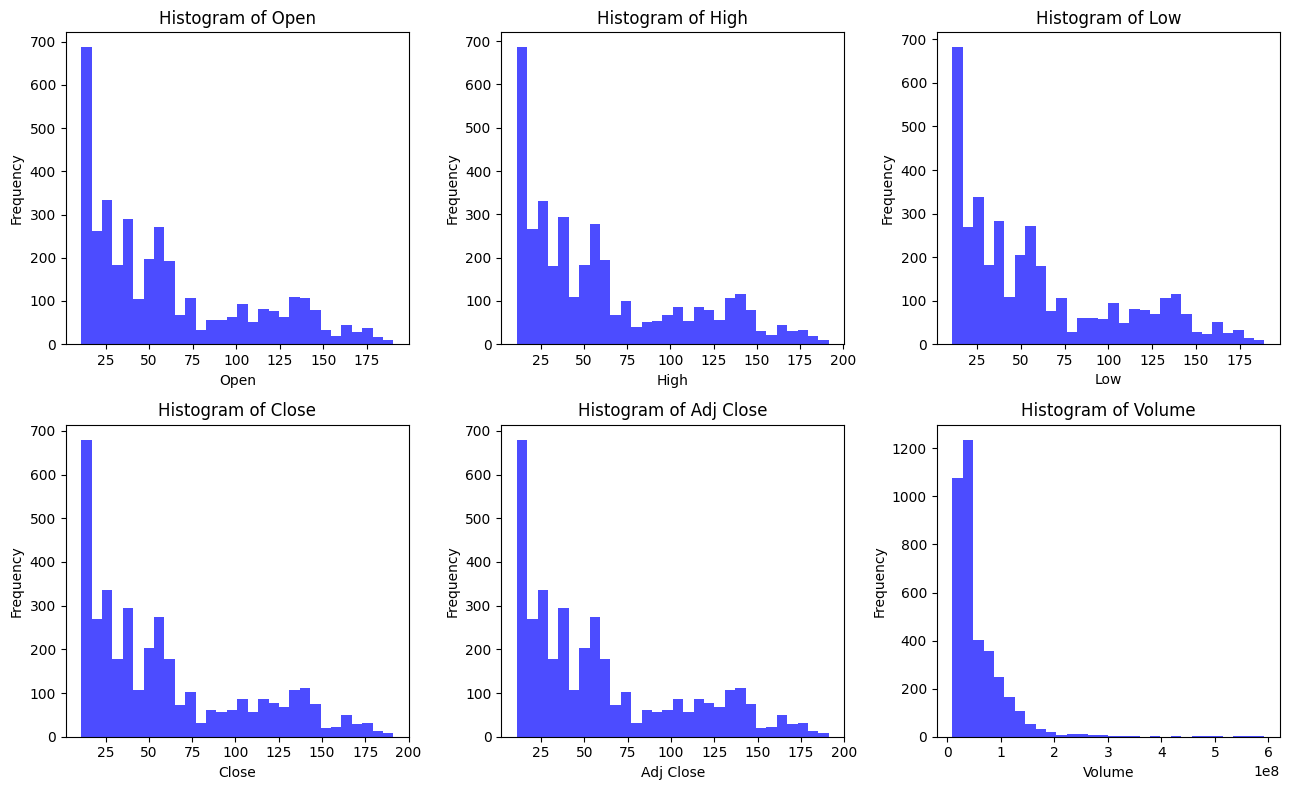

In [48]:
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(13, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    axes[i].hist(data[col], bins=30, color='blue', alpha=0.7)
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

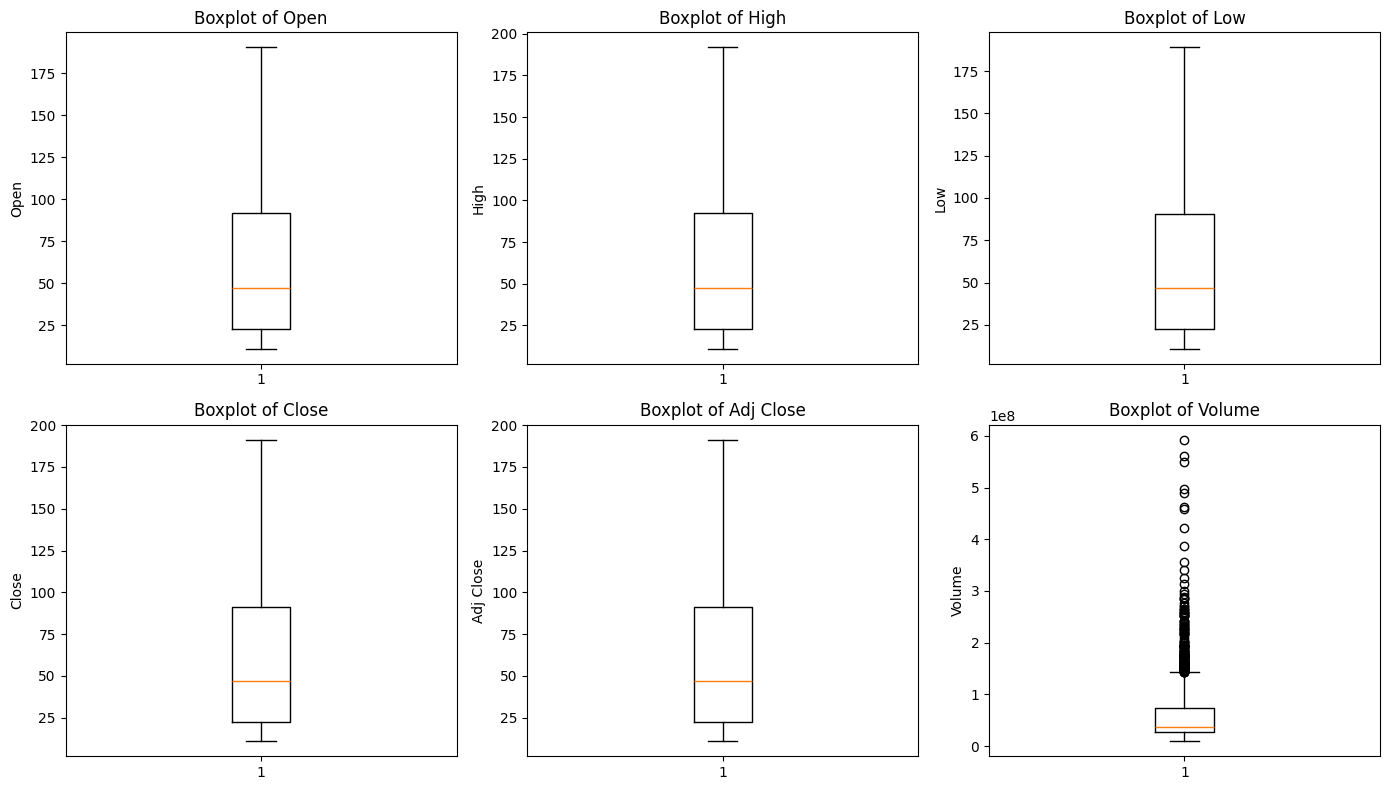

In [49]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    axes[i].boxplot(data[col])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_ylabel(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


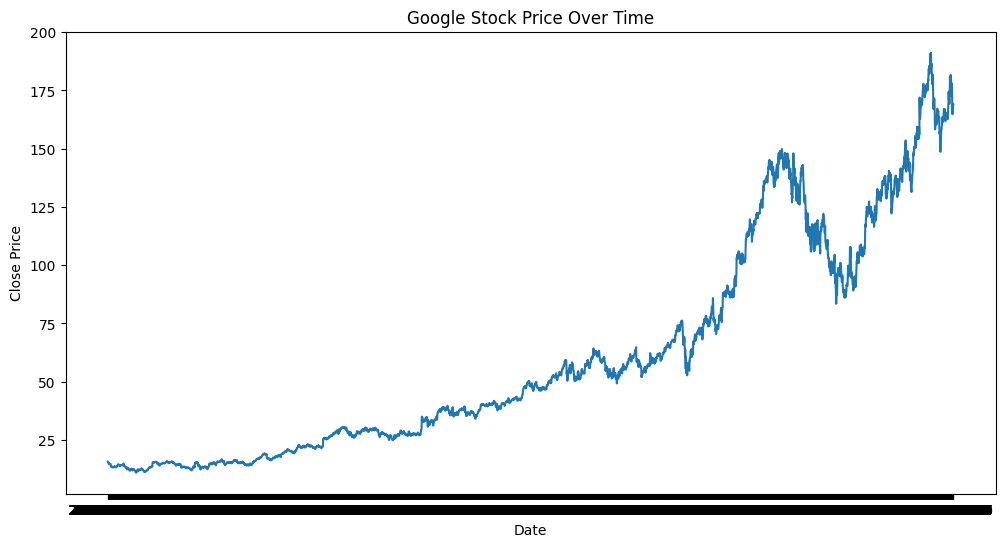

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'])
plt.title('Google Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

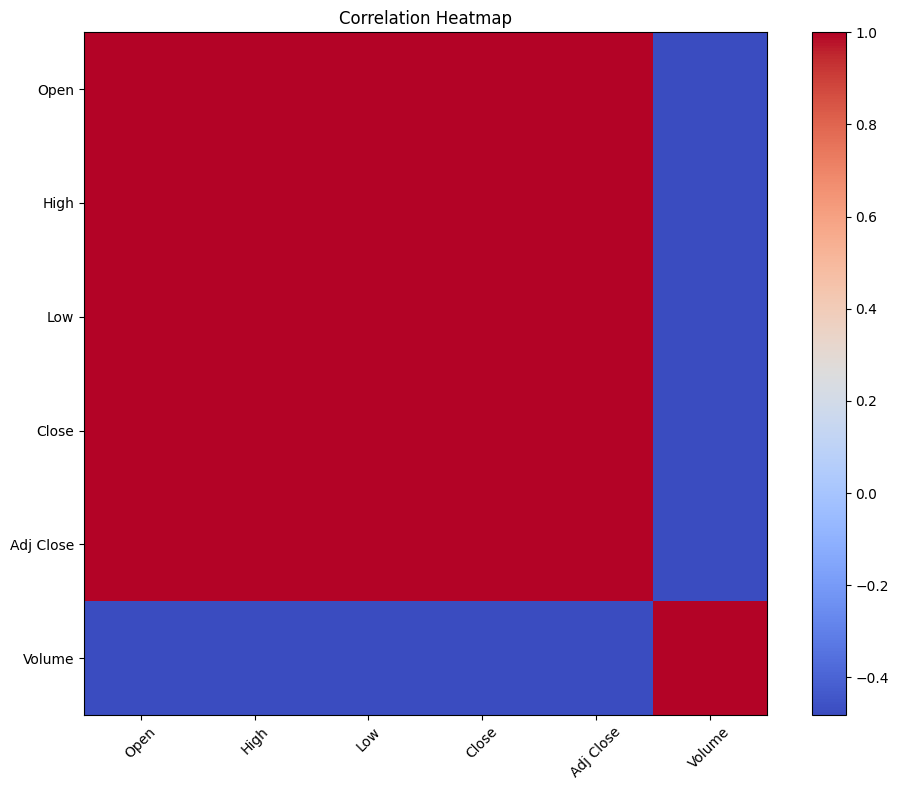

In [51]:
numeric_data = data.select_dtypes(include=np.number)
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), numeric_data.columns, rotation=45)
plt.yticks(range(len(correlation_matrix)), numeric_data.columns)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

In [52]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

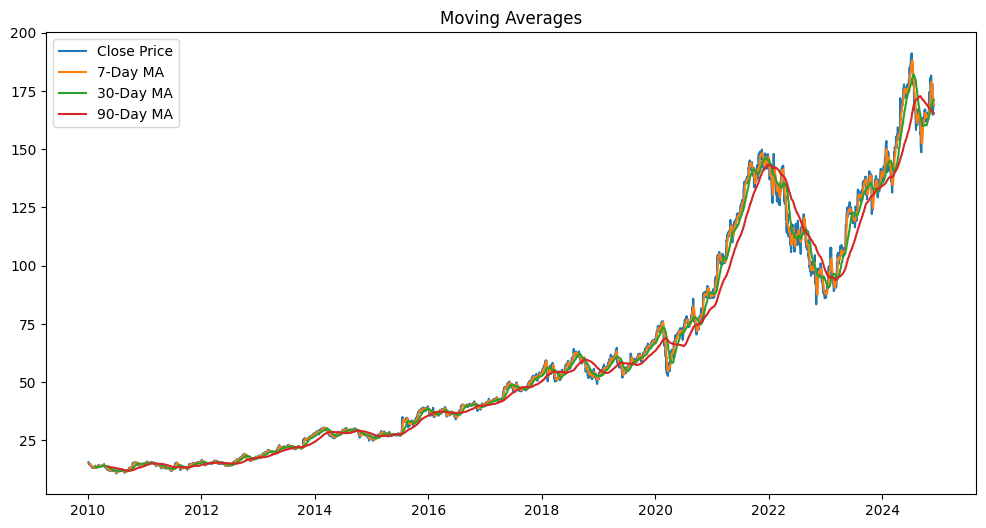

In [53]:
data['MA7'] = data['Close'].rolling(window=7).mean()
data['MA30'] = data['Close'].rolling(window=30).mean()
data['MA90'] = data['Close'].rolling(window=90).mean()
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['MA7'], label='7-Day MA')
plt.plot(data['MA30'], label='30-Day MA')
plt.plot(data['MA90'], label='90-Day MA')
plt.title('Moving Averages')
plt.legend()
plt.show()

In [54]:
data['Daily_Return'] = data['Close'].pct_change()
data['Cumulative_Return'] = (1 + data['Daily_Return']).cumprod()

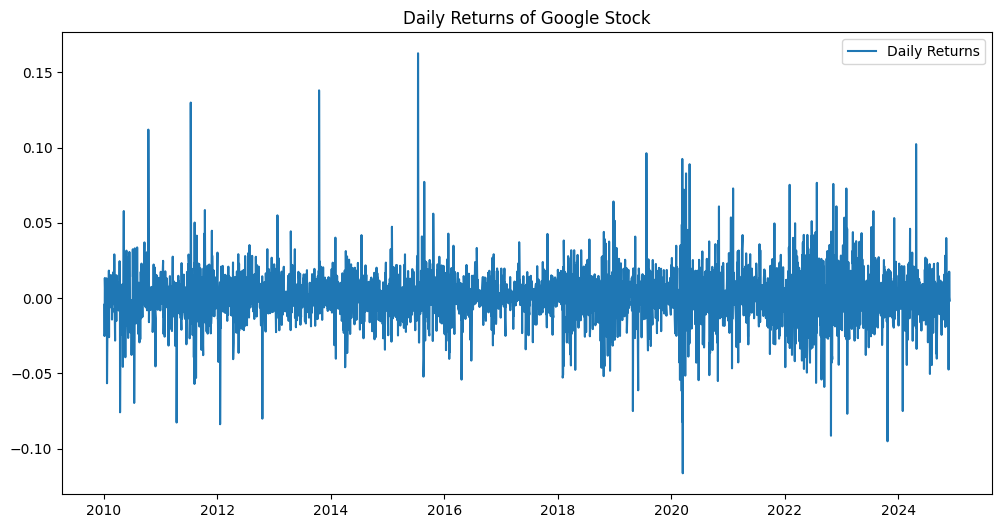

In [55]:
plt.figure(figsize=(12,6))
plt.plot(data['Daily_Return'], label='Daily Returns')
plt.title('Daily Returns of Google Stock')
plt.legend()
plt.show()

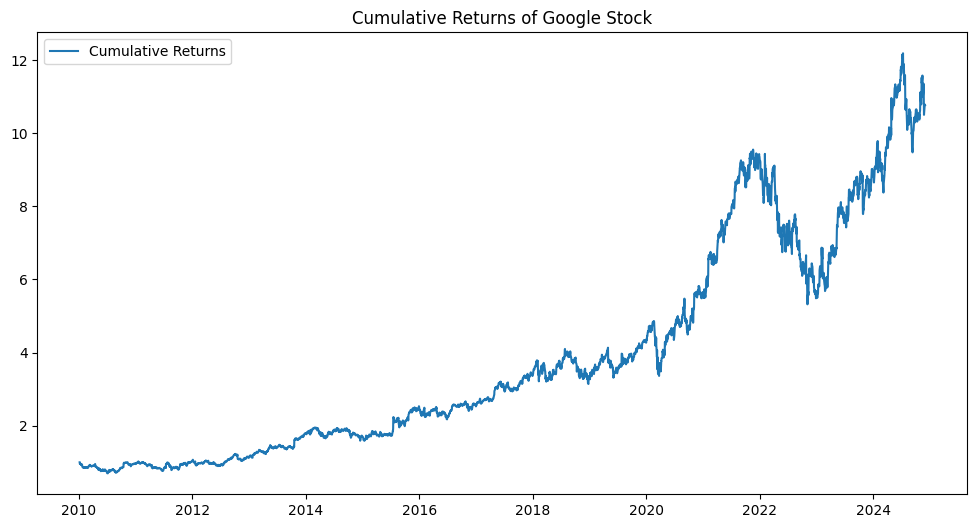

In [56]:
plt.figure(figsize=(12,6))
plt.plot(data['Cumulative_Return'], label='Cumulative Returns')
plt.title('Cumulative Returns of Google Stock')
plt.legend()
plt.show()

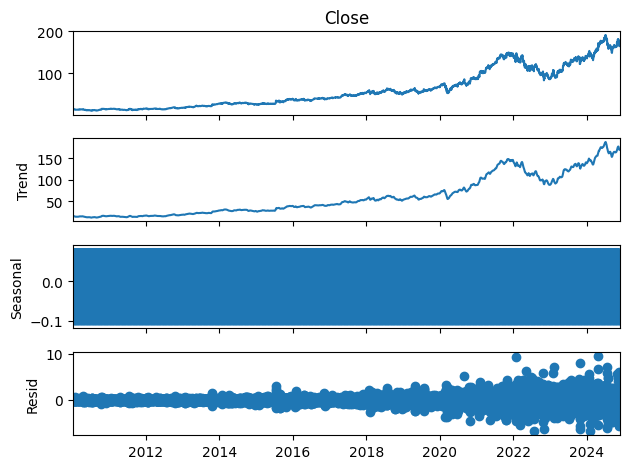

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

data = data.asfreq('D')
data['Close'] = data['Close'].interpolate(method='time')
result = seasonal_decompose(data['Close'], model='additive', period=12)
result.plot()
plt.tight_layout()
plt.show()


***Time Series Forecasting***




In [58]:
train_data = data[:-30]
test_data = data[-30:]

In [59]:
model = ARIMA(train_data['Close'], order=(5,1,0))
model_fit = model.fit()
predictions = model_fit.predict(start=len(train_data), end=len(data)-1)

In [60]:
rmse = math.sqrt(mean_squared_error(test_data['Close'], predictions))
mae = mean_absolute_error(test_data['Close'], predictions)

In [61]:
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 5.0335050737548235
MAE: 4.516774256289849


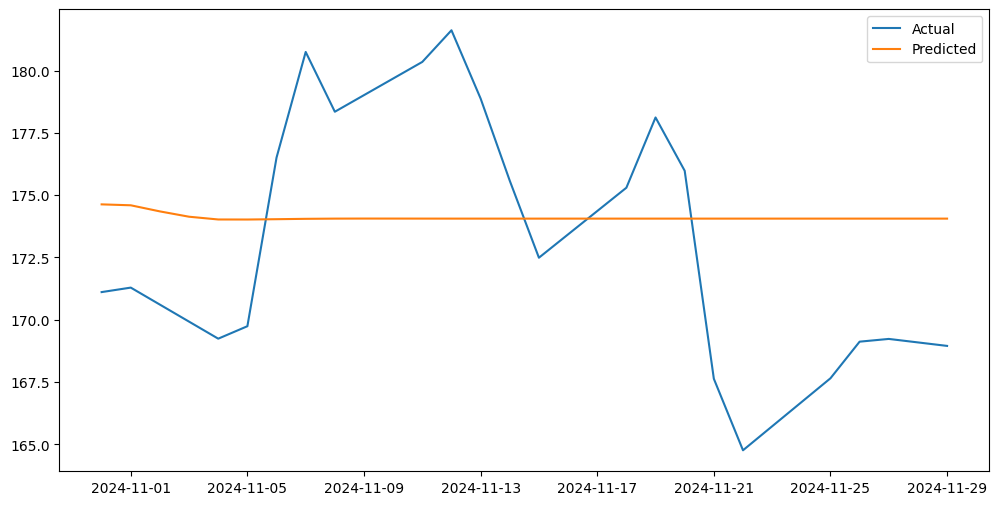

In [62]:
plt.figure(figsize=(12, 6))
plt.plot(test_data['Close'], label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [63]:
future_steps = 30
forecast = model_fit.forecast(steps=future_steps)

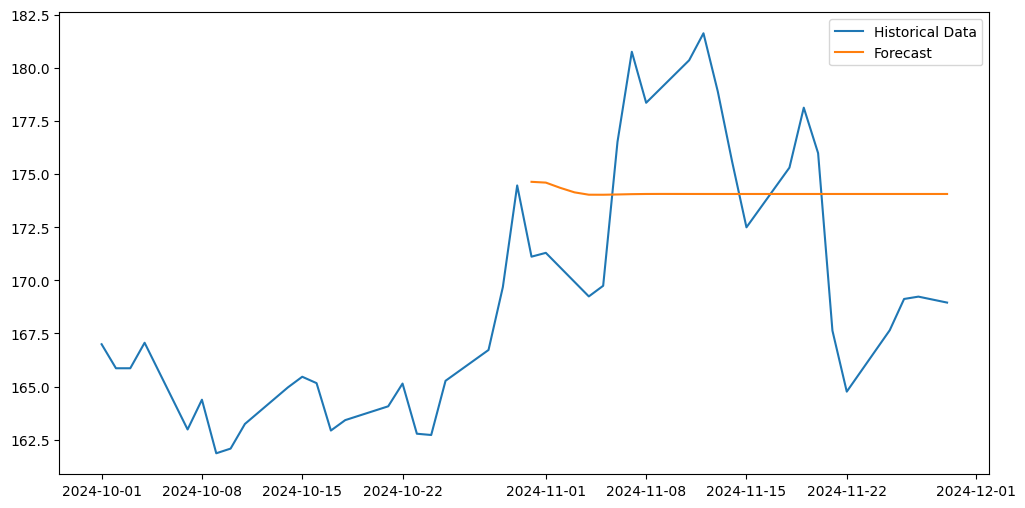

In [64]:
plt.figure(figsize=(12,6))
plt.plot(data['Close'][-60:], label='Historical Data')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.show()

In [65]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Close'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: 0.967714049082664
p-value: 0.9939133393252608


In [66]:
data['Close_diff'] = data['Close'].diff().dropna()


In [67]:
! pip install pmdarima
from pmdarima import auto_arima

model = auto_arima(data['Close'], seasonal=False, trace=True)
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16148.686, Time=8.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16168.473, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16160.117, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16160.259, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16170.254, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16154.488, Time=7.82 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16161.977, Time=7.76 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=16149.325, Time=4.25 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=16149.209, Time=9.34 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16162.080, Time=1.97 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=16148.084, Time=4.49 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=16157.091, Time=1.39 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=16148.960, Time=10.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16161.731, Time=1.07 sec
 ARIMA(0,1,4)(0,0,

In [68]:
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12

In [69]:
model = SARIMAX(data['Close'], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

In [70]:
train_data = data['Close'][:-30]
test_data = data['Close'][-30:]
forecast = results.get_forecast(steps=30)
predicted = forecast.predicted_mean

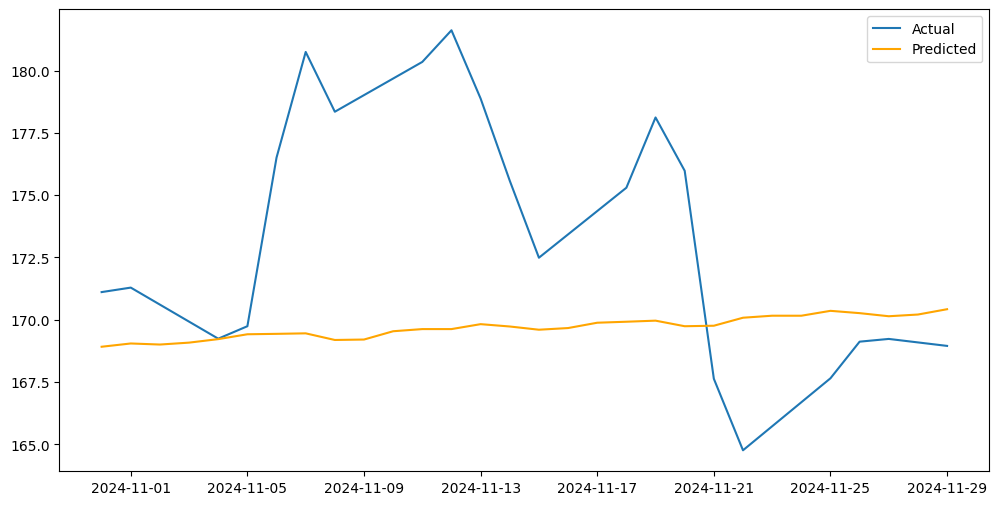

In [71]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label="Actual")
plt.plot(test_data.index, predicted, label="Predicted", color="orange")
plt.legend()
plt.show()

In [72]:
rmse = mean_squared_error(test_data, predicted)
print(f"RMSE: {rmse}")

RMSE: 36.79053735583931
